In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Fri Jan 12 00:14:00 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   25C    P8    14W / 230W |      8MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Model Parts

In [4]:
from model.main.enc_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.latent_layer.min_latent_layer import LatentLayer
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *


### Model Init.

In [5]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]

In [6]:
step = 0
device = 'cuda:0'

model = Model(Encoder(**hp), LatentLayer(**hp), Decoder(**hp))
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))
        
print('done')

encoder 6.004646301269531
encoder.convs 5.989013671875
encoder.linear 0.01563262939453125
latent_layer 0.0
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [7]:
save_dir = '/data/scpark/save/lse/train01.11-10/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, net_g, _, opt_g, _ = load(save_dir, 0, model, optimizer)

total 77340
-rw-rw-r-- 1 scpark scpark    92612  1월 11 22:02 events.out.tfevents.1704978103.GPUSVR01
-rw-rw-r-- 1 scpark scpark 37973949  1월 11 22:01 save_0
-rw-rw-r-- 1 scpark scpark  1079684  1월 11 22:01 events.out.tfevents.1704977549.GPUSVR01
-rw-rw-r-- 1 scpark scpark 37979741  1월 11 22:00 save_10000
-rw-rw-r-- 1 scpark scpark  1079108  1월 11 21:52 events.out.tfevents.1704977018.GPUSVR01
-rw-rw-r-- 1 scpark scpark   977060  1월 11 21:43 events.out.tfevents.1704976543.GPUSVR01
-rw-rw-r-- 1 scpark scpark       40  1월 11 21:35 events.out.tfevents.1704976499.GPUSVR01


### Dataset

In [8]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [9]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [10]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


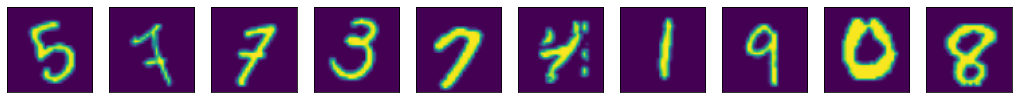

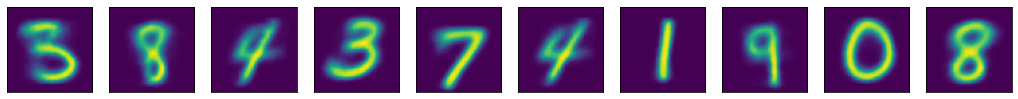

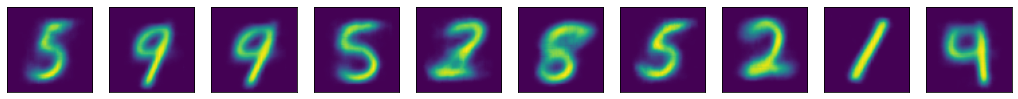

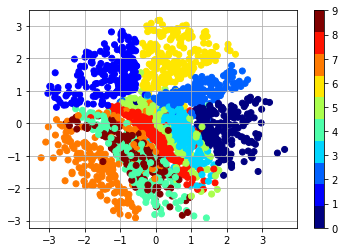

67001
lse_loss 0.09606033563613892
recon_loss 0.10749082267284393
67002
lse_loss 0.10859757661819458
recon_loss 0.116206094622612
67003
lse_loss 0.09740019589662552
recon_loss 0.10975266993045807
67004
lse_loss 0.0985940620303154
recon_loss 0.10143470019102097
67005
lse_loss 0.10418950021266937
recon_loss 0.11822542548179626
67006
lse_loss 0.10272067785263062
recon_loss 0.11074410378932953
67007
lse_loss 0.09526270627975464
recon_loss 0.12245933711528778
67008
lse_loss 0.10269968211650848
recon_loss 0.10078836977481842
67009
lse_loss 0.100181445479393
recon_loss 0.11276771873235703
67010
lse_loss 0.10203078389167786
recon_loss 0.11665956676006317
67011
lse_loss 0.10214505344629288
recon_loss 0.10968418419361115
67012
lse_loss 0.09305782616138458
recon_loss 0.10883355140686035
67013
lse_loss 0.09994415938854218
recon_loss 0.10701503604650497
67014
lse_loss 0.09352807700634003
recon_loss 0.10573738813400269
67015
lse_loss 0.09071872383356094
recon_loss 0.10778360813856125
67016
lse_loss 

67128
lse_loss 0.10982111841440201
recon_loss 0.10463431477546692
67129
lse_loss 0.1056370809674263
recon_loss 0.12312077730894089
67130
lse_loss 0.09968448430299759
recon_loss 0.11572184413671494
67131
lse_loss 0.10337445139884949
recon_loss 0.09597977250814438
67132
lse_loss 0.11802531778812408
recon_loss 0.11766006052494049
67133
lse_loss 0.09252331405878067
recon_loss 0.11508087813854218
67134
lse_loss 0.09967571496963501
recon_loss 0.12648150324821472
67135
lse_loss 0.11065673828125
recon_loss 0.11525142192840576
67136
lse_loss 0.09570418298244476
recon_loss 0.12002649158239365
67137
lse_loss 0.10294757038354874
recon_loss 0.10474895685911179
67138
lse_loss 0.10264696925878525
recon_loss 0.12129271030426025
67139
lse_loss 0.1046862006187439
recon_loss 0.11793413013219833
67140
lse_loss 0.10333810746669769
recon_loss 0.11570112407207489
67141
lse_loss 0.09175987541675568
recon_loss 0.10594522953033447
67142
lse_loss 0.09808329492807388
recon_loss 0.09930139034986496
67143
lse_loss 

67259
lse_loss 0.10471166670322418
recon_loss 0.12112244963645935
67260
lse_loss 0.10554689913988113
recon_loss 0.09994079917669296
67261
lse_loss 0.0965566635131836
recon_loss 0.10190457105636597
67262
lse_loss 0.09730765223503113
recon_loss 0.1236923336982727
67263
lse_loss 0.10904954373836517
recon_loss 0.10599541664123535
67264
lse_loss 0.09561819583177567
recon_loss 0.10921963304281235
67265
lse_loss 0.10878725349903107
recon_loss 0.11013217270374298
67266
lse_loss 0.10299598425626755
recon_loss 0.11778070777654648
67267
lse_loss 0.10565002262592316
recon_loss 0.10862954705953598
67268
lse_loss 0.0918748751282692
recon_loss 0.09895092248916626
67269
lse_loss 0.10213275253772736
recon_loss 0.11872820556163788
67270
lse_loss 0.10320378094911575
recon_loss 0.11593206971883774
67271
lse_loss 0.10743176192045212
recon_loss 0.1234932467341423
67272
lse_loss 0.08934924006462097
recon_loss 0.11593940109014511
67273
lse_loss 0.09497063606977463
recon_loss 0.10978545248508453
67274
lse_loss

67384
lse_loss 0.0946882888674736
recon_loss 0.11035241931676865
67385
lse_loss 0.10442683100700378
recon_loss 0.10901768505573273
67386
lse_loss 0.11308462917804718
recon_loss 0.11237113177776337
67387
lse_loss 0.09711857885122299
recon_loss 0.10777943581342697
67388
lse_loss 0.10813461989164352
recon_loss 0.09466242045164108
67389
lse_loss 0.10162461549043655
recon_loss 0.11949964612722397
67390
lse_loss 0.10432180017232895
recon_loss 0.10537903010845184
67391
lse_loss 0.10367792844772339
recon_loss 0.10900425910949707
67392
lse_loss 0.0987461507320404
recon_loss 0.10614141821861267
67393
lse_loss 0.10033437609672546
recon_loss 0.11214321851730347
67394
lse_loss 0.10835607349872589
recon_loss 0.11526109278202057
67395
lse_loss 0.09367405623197556
recon_loss 0.10877475142478943
67396
lse_loss 0.09546764940023422
recon_loss 0.10930492728948593
67397
lse_loss 0.1003774031996727
recon_loss 0.11506830155849457
67398
lse_loss 0.08960683643817902
recon_loss 0.10227113217115402
67399
lse_los

67510
lse_loss 0.09483633190393448
recon_loss 0.11801095306873322
67511
lse_loss 0.1119556874036789
recon_loss 0.12183015793561935
67512
lse_loss 0.09562747180461884
recon_loss 0.10527248680591583
67513
lse_loss 0.09525808691978455
recon_loss 0.10528254508972168
67514
lse_loss 0.10442851483821869
recon_loss 0.10708620399236679
67515
lse_loss 0.09860990196466446
recon_loss 0.1091717928647995
67516
lse_loss 0.09132327884435654
recon_loss 0.11073704808950424
67517
lse_loss 0.10324850678443909
recon_loss 0.10654918849468231
67518
lse_loss 0.09803369641304016
recon_loss 0.10963352024555206
67519
lse_loss 0.0973716527223587
recon_loss 0.1234302744269371
67520
lse_loss 0.11249518394470215
recon_loss 0.12383665889501572
67521
lse_loss 0.09993433952331543
recon_loss 0.11940056085586548
67522
lse_loss 0.11828471720218658
recon_loss 0.11011668294668198
67523
lse_loss 0.10448580980300903
recon_loss 0.10229193419218063
67524
lse_loss 0.10986967384815216
recon_loss 0.117771677672863
67525
lse_loss 0

67636
lse_loss 0.09271588921546936
recon_loss 0.11276646703481674
67637
lse_loss 0.09114541113376617
recon_loss 0.11730746924877167
67638
lse_loss 0.10212392359972
recon_loss 0.11032150685787201
67639
lse_loss 0.1089424416422844
recon_loss 0.11552029848098755
67640
lse_loss 0.10199176520109177
recon_loss 0.12079322338104248
67641
lse_loss 0.10407846421003342
recon_loss 0.10974246263504028
67642
lse_loss 0.09655086696147919
recon_loss 0.1176954135298729
67643
lse_loss 0.08694269508123398
recon_loss 0.11037768423557281
67644
lse_loss 0.0882437601685524
recon_loss 0.11549435555934906
67645
lse_loss 0.0958113819360733
recon_loss 0.10186690092086792
67646
lse_loss 0.09716146439313889
recon_loss 0.11102358996868134
67647
lse_loss 0.10644744336605072
recon_loss 0.12674802541732788
67648
lse_loss 0.09647057950496674
recon_loss 0.11419057846069336
67649
lse_loss 0.09940686076879501
recon_loss 0.12178435921669006
67650
lse_loss 0.09528549760580063
recon_loss 0.11163663119077682
67651
lse_loss 0.

recon_loss 0.09284325689077377
67763
lse_loss 0.10528932511806488
recon_loss 0.11527770757675171
67764
lse_loss 0.09377468377351761
recon_loss 0.11265109479427338
67765
lse_loss 0.10676408559083939
recon_loss 0.11247715353965759
67766
lse_loss 0.10127920657396317
recon_loss 0.11111937463283539
67767
lse_loss 0.09984764456748962
recon_loss 0.10835613310337067
67768
lse_loss 0.09664785861968994
recon_loss 0.11583779752254486
67769
lse_loss 0.11116237193346024
recon_loss 0.1046537384390831
67770
lse_loss 0.09630318731069565
recon_loss 0.108355313539505
67771
lse_loss 0.08719206601381302
recon_loss 0.10465048253536224
67772
lse_loss 0.10432285815477371
recon_loss 0.11362063139677048
67773
lse_loss 0.10281706601381302
recon_loss 0.11214715242385864
67774
lse_loss 0.09302733838558197
recon_loss 0.1043025478720665
67775
lse_loss 0.09858580678701401
recon_loss 0.10443417727947235
67776
lse_loss 0.09779071062803268
recon_loss 0.12094708532094955
67777
lse_loss 0.11530641466379166
recon_loss 0.1

67889
lse_loss 0.09417256712913513
recon_loss 0.09947102516889572
67890
lse_loss 0.09783998876810074
recon_loss 0.10752641409635544


KeyboardInterrupt: 

In [11]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        data = preprocess(batch)
        
        # Forward
        model.train()
        model.zero_grad()
        data = model(data, M=10000, sigma=1e-1)
        
        # Backward
        loss = 0
        for key in data.keys():
            if 'loss' in key:
                loss = loss + data[key]
                writer.add_scalar(key, data[key].item(), step)
                print(key, data[key].item())
        loss.backward()
        optimizer.step()
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model.eval()
            with torch.no_grad():
                data = model(data, M=1000, sigma=1e-1)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save(save_dir, step, model, optimizer)
                
        step += 1
        